# Lampiran Query Google Cloud Platform

---

    SELECT limit_balance, sex, education_level, marital_status, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, default_payment_next_month
    FROM `bigquery-public-data.ml_datasets.credit_card_default`
    LIMIT 27986;

---

# Memprediksi Pembayaran Kartu Kredit dengan Berbagai Algoritma

`Faisal Kengo (FTDS Remote Batch 014)`

## Perkenalan

Nama saya Faisal Kengo, kali ini saya akan memprediksi apakah seseorang perlu membayar tagihan kartu kredit mereka atau tidak berdasarkan beberapa faktor yang tersedia di dalam *dataset*seperti batas kredit, jenis kelamin, tingkat pendidikan, status pernikahan, umur, dan detil tagihan dan pembayaran kartu kreditnya. *Dataset* diambil dari Google Cloud Platform BigQuery dan kemudian dianalisa dengan menggunakan berbagai macam model algoritma klasifikasi untuk melakukan prediksi tersebut.

### Tujuan Utama

Tujuan dari penyusunan laporan ini adalah sebagai berikut:

* Membandingkan dan memilih model algoritma apa yang sesuai untuk diterapkan di dalam *dataset* dengan menggunakan metode *cross-validation*,

* Memprediksi klasifikasi dari `default_payment_next_month` dari dataset yang diambil dengan menggunakan model algoritma terbaik yang telah dipilih melalui metode *cross-validation* dan telah diatur lebih lanjut *hyperparameter*-nya.

## Pengolahan dan Analisa *Dataset*

Sebelum kita memulai proses analisa data, kita akan mengimpor *library* yang akan digunakan untuk mengolah *dataset* serta memuat *dataset* yang telah kita ambil dari Google Cloud Platform.

Pertama-tama kita akan mengimpor terlebih dahulu *library* yang akan kita gunakan.

### Impor *Library*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report

### Memuat *Dataset*

Setelah kita memuat *library* yang akan kita gunakan, kita akan muat *dataset* yang telah kita ambil dari Google Cloud Platform.

In [2]:
df = pd.read_csv("h8dsft_P1M1_FaisalKengo.csv")

Lalu kita akan tampilkan bagian awal dan akhir dari *dataset* tersebut.

In [3]:
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000,1,1,2,39,0,0,0,0,0,...,50803,30789,15874,1800,2000,3000,2000,2000,2000,0
1,110000,2,1,2,29,0,0,0,0,0,...,32489,26354,20221,2000,2010,3000,3000,3000,1000,0
2,270000,1,1,2,36,0,0,0,2,0,...,40335,37165,22156,10076,4018,14,2051,2000,0,0
3,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
4,50000,1,1,2,24,0,0,0,0,0,...,19837,19855,20151,1367,1606,692,709,721,692,0


In [4]:
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,210000,2,2,1,39,-1,-1,-1,-1,-2,...,0,0,12000,0,28428,0,0,12000,33664,0
2961,280000,2,1,1,41,2,-1,-1,-1,-2,...,0,0,244,6859,486,0,0,244,0,0
2962,80000,1,1,2,28,1,-1,-1,-1,-2,...,0,0,0,47,207,0,0,0,0,0
2963,200000,1,2,1,53,1,-1,-1,-2,-2,...,0,0,6753,2920,0,0,0,6753,0,1
2964,20000,2,1,2,24,-1,-1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


### *Exploratory Data Analysis*

Pertama-tama kita akan melihat terlebih dahulu bagaimana data-data yang kita miliki di dalam *dataset* yang sudah dimuat dengan perintah `.info()`:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

Dari perintah di atas kita dapat mengetahui data-data apa saja yang terdapat di dalam *dataset* yang kita miliki, diantaranya batas kredit, jenis kelamin, tingkat pendidikan, status pernikahan, umur, dan detil tagihan dan pembayaran kartu kreditnya. *Dataset* berisikan 2965 buah data yang keseluruhan datanya merupakan data numerik. Namun, tidak semua data numerik ini merupakan data numerik murni. Apabila kita lihat deskripsi skema dari *dataset* yang tersedia di Google Cloud Platform, kita mendapati bahwa beberapa kolom merupakan data kategorik yang sudah dinumerisasi. Berikut adalah deskripsi dari *dataset* yang kita miliki:

---

    Gender (1=male, 2=female)

    Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

    Marital status (1=married, 2=single, 3=others)

    Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

    Default payment (1=yes, 0=no)

---

Data-data yang tercantum di atas merupakan kolom dengan data kategorik yang sudah dinumerisasi. Nilai kolom selain yang tercantum di atas murni berbentuk numerik. Selain itu, kita juga mengetahui bahwa data diambil dari rentang waktu April 2005 hingga September 2005.

Selanjutnya kita akan periksa deskripsi matematika dari data yang kita miliki dengan menggunakan perintah `.describe()`.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_balance,2965.0,163369.308600,125030.415472,10000.0,50000.0,140000.0,230000.0,800000.0
sex,2965.0,1.607757,0.488333,1.0,1.0,2.0,2.0,2.0
education_level,2965.0,1.849578,0.778184,0.0,1.0,2.0,2.0,6.0
marital_status,2965.0,1.559865,0.522317,0.0,1.0,2.0,2.0,3.0
age,2965.0,35.193255,9.109439,21.0,28.0,34.0,41.0,69.0
pay_0,2965.0,0.005059,1.114395,-2.0,-1.0,0.0,0.0,8.0
pay_2,2965.0,-0.122428,1.180784,-2.0,-1.0,0.0,0.0,7.0
pay_3,2965.0,-0.141653,1.183630,-2.0,-1.0,0.0,0.0,7.0
pay_4,2965.0,-0.185160,1.178322,-2.0,-1.0,0.0,0.0,8.0
pay_5,2965.0,-0.225295,1.159003,-2.0,-1.0,0.0,0.0,7.0


Dari perintah di atas, kita dapat mengetahui beberapa hal, di antaranya:

* Batas kredit dari data yang tercatat berada pada rentang 10000 NTD hingga 800000 NTD dengan rata-rata batas kredit sebesar 163369.31 NTD. Namun, karena batas kredit umumnya berada pada inkremen 10000, maka kita dapat mengetahui kalau data ini dapat diinterpretasikan sebagai data kategorik ordinal,

* Rentang umur dari data yang tercatat berada pada rentang usia 21 tahun hingga usia 69 tahun, dengan rata-rata orang yang tercatat berusia 35 tahun.

* `bill_amt` dan `pay_amt` merupakan besar tagihan dan besar pembayaran tagihan yang dilakukan oleh pemilik kartu kredit dengan nilai tagihan berada pada rentang rata-rata sebesar 39773.07 NTD sampai dengan 52118.31 NTD dan nilai pembayaran yang berada pada rentang rata-rata sebesar 4561.38 NTD sampai dengan 6348.9 NTD.

Sebelum kita ubah kolom yang memuat nilai batas kredit, kita akan lihat dulu bagaimana keseluruhan distribusinya dengan menggunakan plot histogram. Pertama-tama kita harus mengetahui dulu data-data apa saja yang terdapat di dalam kolom `limit_balance` beserta jumlahnya.

In [7]:
df.pay_0.value_counts().sort_index().index[()]

Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [8]:
df.limit_balance.value_counts().sort_index()

10000      46
20000     203
30000     148
40000      26
50000     348
60000      68
70000      76
80000     145
90000      71
100000    123
110000     54
120000     80
130000     69
140000     83
150000    122
160000     62
170000     52
180000     97
190000     12
200000    150
210000     84
220000     43
230000     68
240000     56
250000     28
260000     70
270000     19
280000     50
290000     37
300000     67
310000     28
320000     32
330000     16
340000     15
350000     24
360000     78
370000      8
380000     16
390000     16
400000     25
410000     12
420000     20
430000      5
440000      6
450000      9
460000      8
470000      7
480000      5
490000      8
500000     56
510000      4
530000      3
560000      1
620000      1
680000      1
700000      1
750000      1
780000      1
800000      1
Name: limit_balance, dtype: int64

Setelah kita mengetahui persebaran nilai batas kreditnya, kita akan membuat grafik histogramnya.

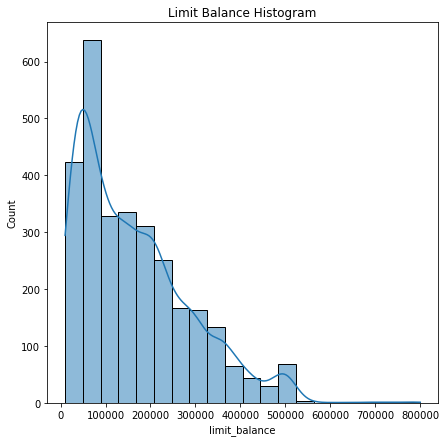

In [9]:
plt.figure(figsize = (7, 7))

sns.histplot(df["limit_balance"], bins = 20, kde = True)
plt.title("Limit Balance Histogram")

plt.show()

Dari grafik di atas, kita dapat ketahui bahwa mayoritas orang memiliki nilai batas kredit di bawah 200000 NTD.

Kemudian kita akan lihat bagaimana persebaran jenis kelamin dari pemegang kartu kredit yang tercatat di dalam data:

In [10]:
df.sex.value_counts().sort_index()

1    1163
2    1802
Name: sex, dtype: int64

Setelah itu kita akan buat visualisasi untuk interpretasi datanya dengan perintah berikut:

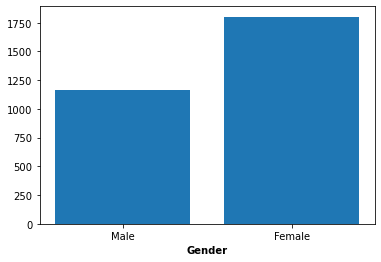

In [11]:
height = df.sex.value_counts().sort_index()

bars = ("Male", "Female")
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.xlabel("Gender", fontweight = "bold")

plt.show()

Dari grafik di atas, kita mengetahui bahwa lebih banyak wanita yang memegang kartu kredit dibandingkan dengan pria dengan rasio 3:2.

Selanjutnya kita akan melihat persebaran tingkat pendidikan pemegang kartu kredit yang tercatat di dalam data.

In [12]:
df.education_level.value_counts().sort_index()

0       2
1    1039
2    1400
3     483
4      13
5      24
6       4
Name: education_level, dtype: int64

Kemudian kita akan buat visualiasinya, sama seperti sebelumnya, dengan menggunakan plot batang.

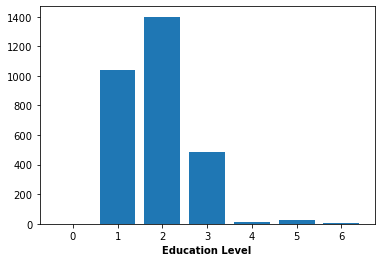

In [13]:
height = df.education_level.value_counts().sort_index()

bars = (df.education_level.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.xlabel("Education Level", fontweight = "bold")

plt.show()

Dari grafik di atas kita mengetahui bahwa mayoritas pemegang kartu kredit merupakan mahasiswa, baik dari tingkat sarjana, magister, ataupun doktor. Pada data juga terlihat ada indeks '0' yang tidak tercatat di dalam skema deskriptif *dataset* dan indeks '5' dan '6' yang sebenarnya menggambarkan hal yang sama, yaitu tingkat pendidikan yang tidak diketahui. Ketiga indeks tersebut nantinya akan kita gabungkan dengan data 'others' yang berada pada indeks 4 pada grafik.

Sekarang kita akan melihat persebaran status pernikahan dari pemegang kartu kredit yang tercatat di dalam data.

In [14]:
df.marital_status.value_counts().sort_index()

0       4
1    1332
2    1594
3      35
Name: marital_status, dtype: int64

Sama seperti sebelumnya, kita akan buat visualisasi dari data tersebut dengan plot batang.

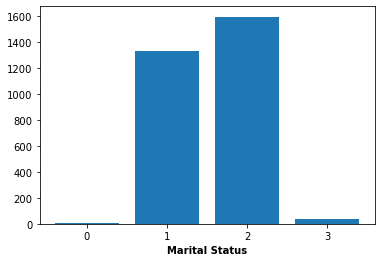

In [15]:
height = df.marital_status.value_counts().sort_index()

bars = (df.marital_status.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.xlabel("Marital Status", fontweight = "bold")

plt.show()

Dari grafik tersebut dapat diketahui bahwa mayoritas pemegang kartu kredit tidak memiliki pasangan. Selain itu, ada indeks '0' yang tidak tercatat di dalam skema deskriptif dan nantinya akan kita masukkan ke dalam indeks '3' yang mewakili nilai 'others'.

Selanjutnya kita akan membuat grafik persebaran umur pemegang kartu kredit yang tercatat di dalam data.

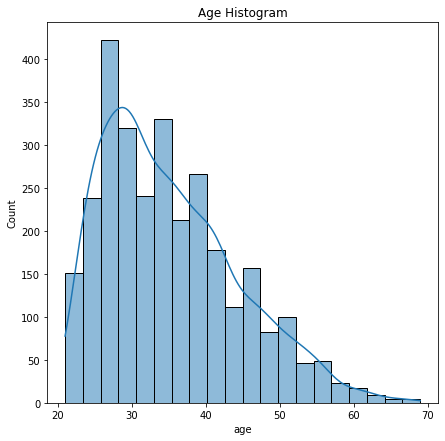

In [16]:
plt.figure(figsize = (7, 7))

sns.histplot(df["age"], bins = 20, kde = True)
plt.title("Age Histogram")

plt.show()

Dari grafik di atas, kita dapat mengetahui bahwa mayoritas pemegang kartu kredit berada pada rentang usia 25-40 tahun. 

Selanjutnya kita akan melihat bagaimana distribusi status pembayaran pemegang kredit dari bulan April sampai bulan Agustus.

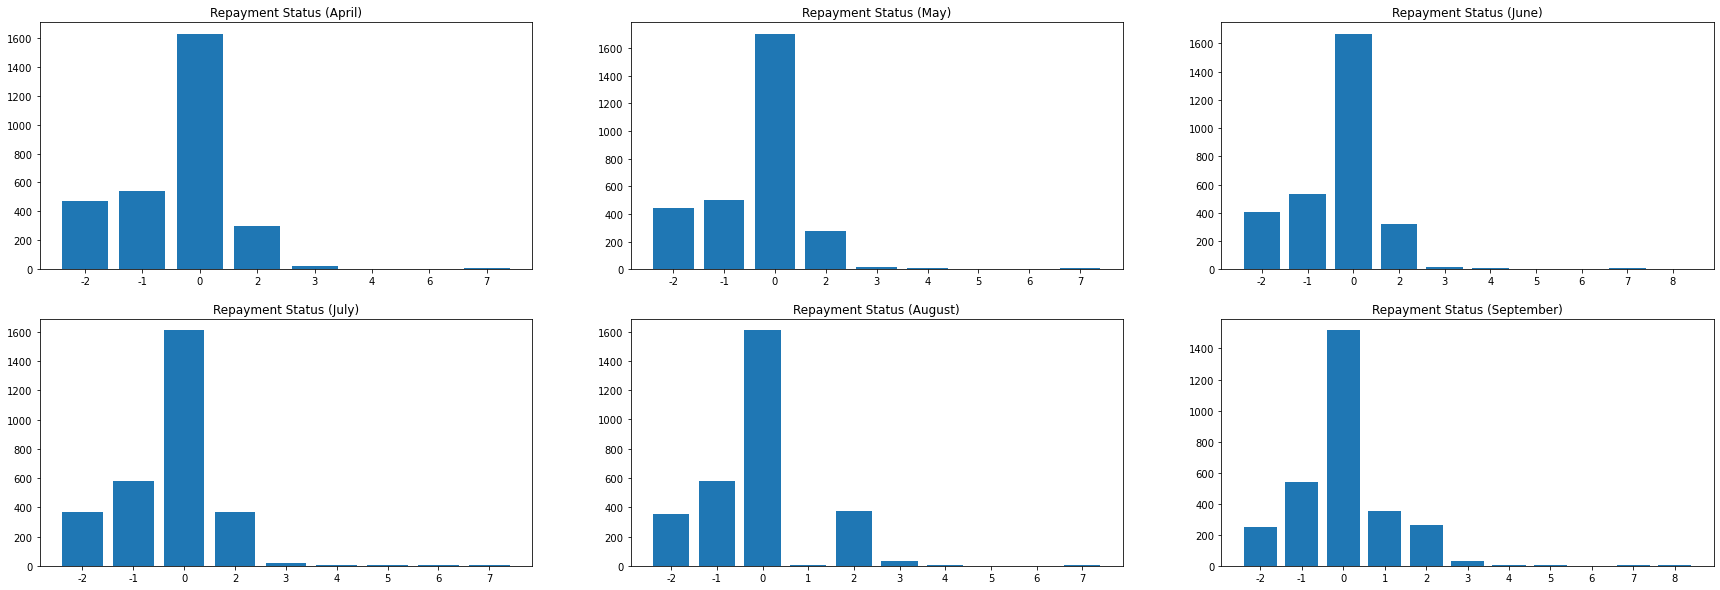

In [17]:
plt.figure(figsize = (30, 10))

plt.subplot(2, 3, 1)
height = df.pay_6.value_counts().sort_index()

bars = (df.pay_6.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (April)")

plt.subplot(2, 3, 2)
height = df.pay_5.value_counts().sort_index()

bars = (df.pay_5.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (May)")

plt.subplot(2, 3, 3)
height = df.pay_4.value_counts().sort_index()

bars = (df.pay_4.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (June)")

plt.subplot(2, 3, 4)
height = df.pay_3.value_counts().sort_index()

bars = (df.pay_3.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (July)")

plt.subplot(2, 3, 5)
height = df.pay_2.value_counts().sort_index()

bars = (df.pay_2.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (August)")

plt.subplot(2, 3, 6)
height = df.pay_0.value_counts().sort_index()

bars = (df.pay_0.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.title("Repayment Status (September)")
plt.show()

Dari grafik di atas, kita mengetahui bahwa mayoritas pemegang kartu kredit membayar tagihannya tepat waktu atau lebih cepat dari itu. Untuk kepentingan analisis nanti, kita akan memasukkan indeks '-2' dan '0' yang tidak terdapat di dalam skema deskripsi ke dalam indeks '-1' dan kita ubah namanya ke indeks '0'.

Selain itu kita akan lihat bagaimana distribusi tagihan pembayaran kartu kredit yang tersisa dan tercatat di dalam data dari bulan April hingga bulan September.

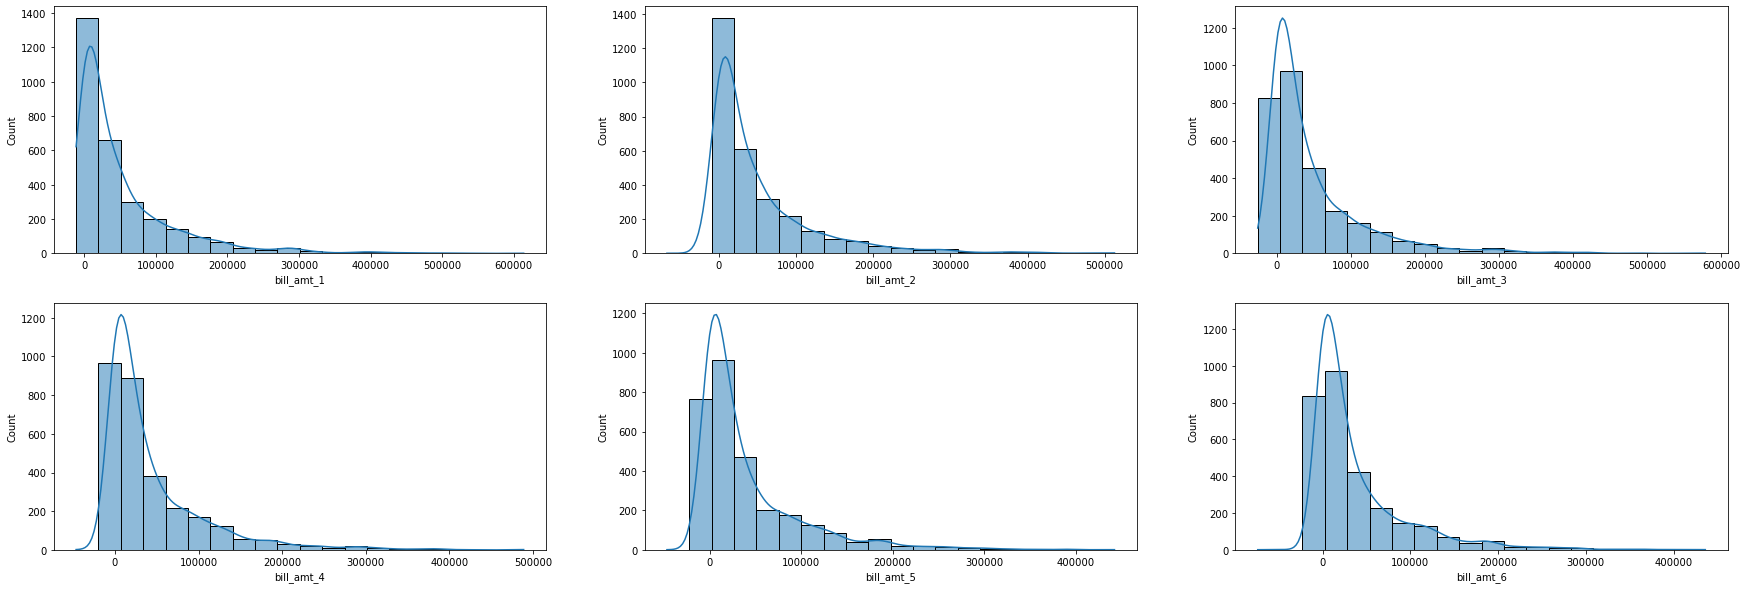

In [18]:
plt.figure(figsize = (30, 10))
plt.subplot(2, 3, 1)
sns.histplot(df["bill_amt_1"], bins = 20, kde = True)
plt.subplot(2, 3, 2)
sns.histplot(df["bill_amt_2"], bins = 20, kde = True)
plt.subplot(2, 3, 3)
sns.histplot(df["bill_amt_3"], bins = 20, kde = True)
plt.subplot(2, 3, 4)
sns.histplot(df["bill_amt_4"], bins = 20, kde = True)
plt.subplot(2, 3, 5)
sns.histplot(df["bill_amt_5"], bins = 20, kde = True)
plt.subplot(2, 3, 6)
sns.histplot(df["bill_amt_6"], bins = 20, kde = True)
plt.show()

Dari grafik ini kita melihat bahwa mayoritas orang tidak memiliki sisa tagihan di dalam kartu kredit milik mereka.

Selanjutnya kita akan melihat bagaimana distribusi jumlah pembayaran tambahan tagihan kartu kredit yang dilakukan dan tercatat di dalam data dari bulan April hingga bulan September.

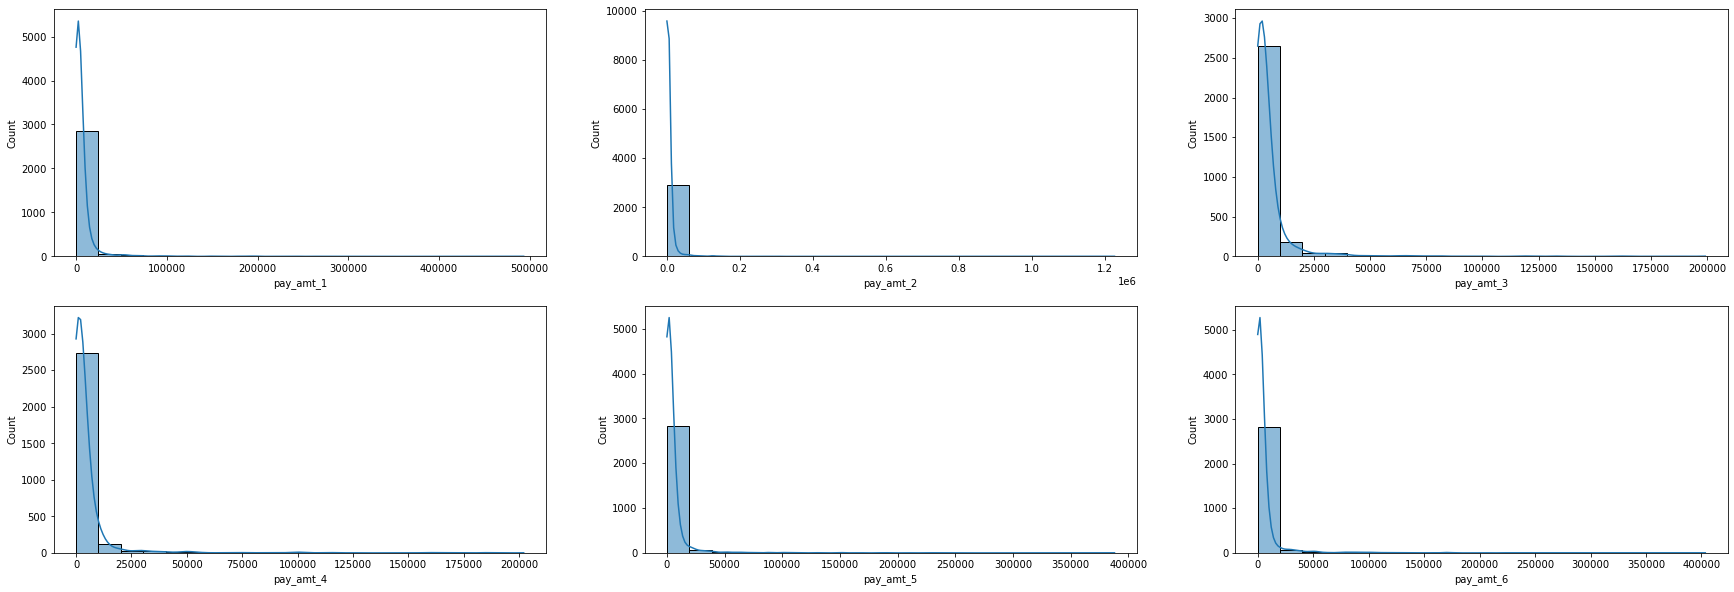

In [19]:
plt.figure(figsize = (30, 10))
plt.subplot(2, 3, 1)
sns.histplot(df["pay_amt_1"], bins = 20, kde = True)
plt.subplot(2, 3, 2)
sns.histplot(df["pay_amt_2"], bins = 20, kde = True)
plt.subplot(2, 3, 3)
sns.histplot(df["pay_amt_3"], bins = 20, kde = True)
plt.subplot(2, 3, 4)
sns.histplot(df["pay_amt_4"], bins = 20, kde = True)
plt.subplot(2, 3, 5)
sns.histplot(df["pay_amt_5"], bins = 20, kde = True)
plt.subplot(2, 3, 6)
sns.histplot(df["pay_amt_6"], bins = 20, kde = True)
plt.show()

Dari sini kita dapat melihat bahwa mayoritas orang tidak melakukan pembayaran tambahan tagihan kartu kredit. Hal ini konsisten dengan grafik sebelumnya yang menampilkan bahwa mayoritas pengguna kartu kredit membayarkan uang kreditnya tepat waktu.

Terakhir, kita akan melihat distribusi apakah seseorang wajib melakukan pembayaran kartu kredit di bulan Oktober 2005 atau tidak.

In [20]:
df.default_payment_next_month.value_counts()

0    2330
1     635
Name: default_payment_next_month, dtype: int64

Setelah itu kita akan buat visualisasinya:

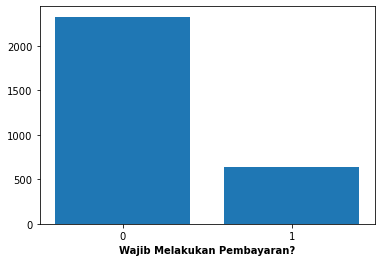

In [21]:
height = df.default_payment_next_month.value_counts().sort_index()

bars = (df.default_payment_next_month.value_counts().sort_index().index[()])
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.xlabel("Wajib Melakukan Pembayaran?", fontweight = "bold")

plt.show()

Dari visualisasi di atas, terlihat bahwa mayoritas pemegang kartu kredit tidak perlu wajib membayar tagihan kredit mereka di bulan selanjtnya dengan rasio kurang lebih 5:1.

Kemudian kita akan periksa *heat map* dari *dataset* yang kita miliki untuk menentukan fitur apa saja yang akan dimasukkan ke dalam model nantinya.

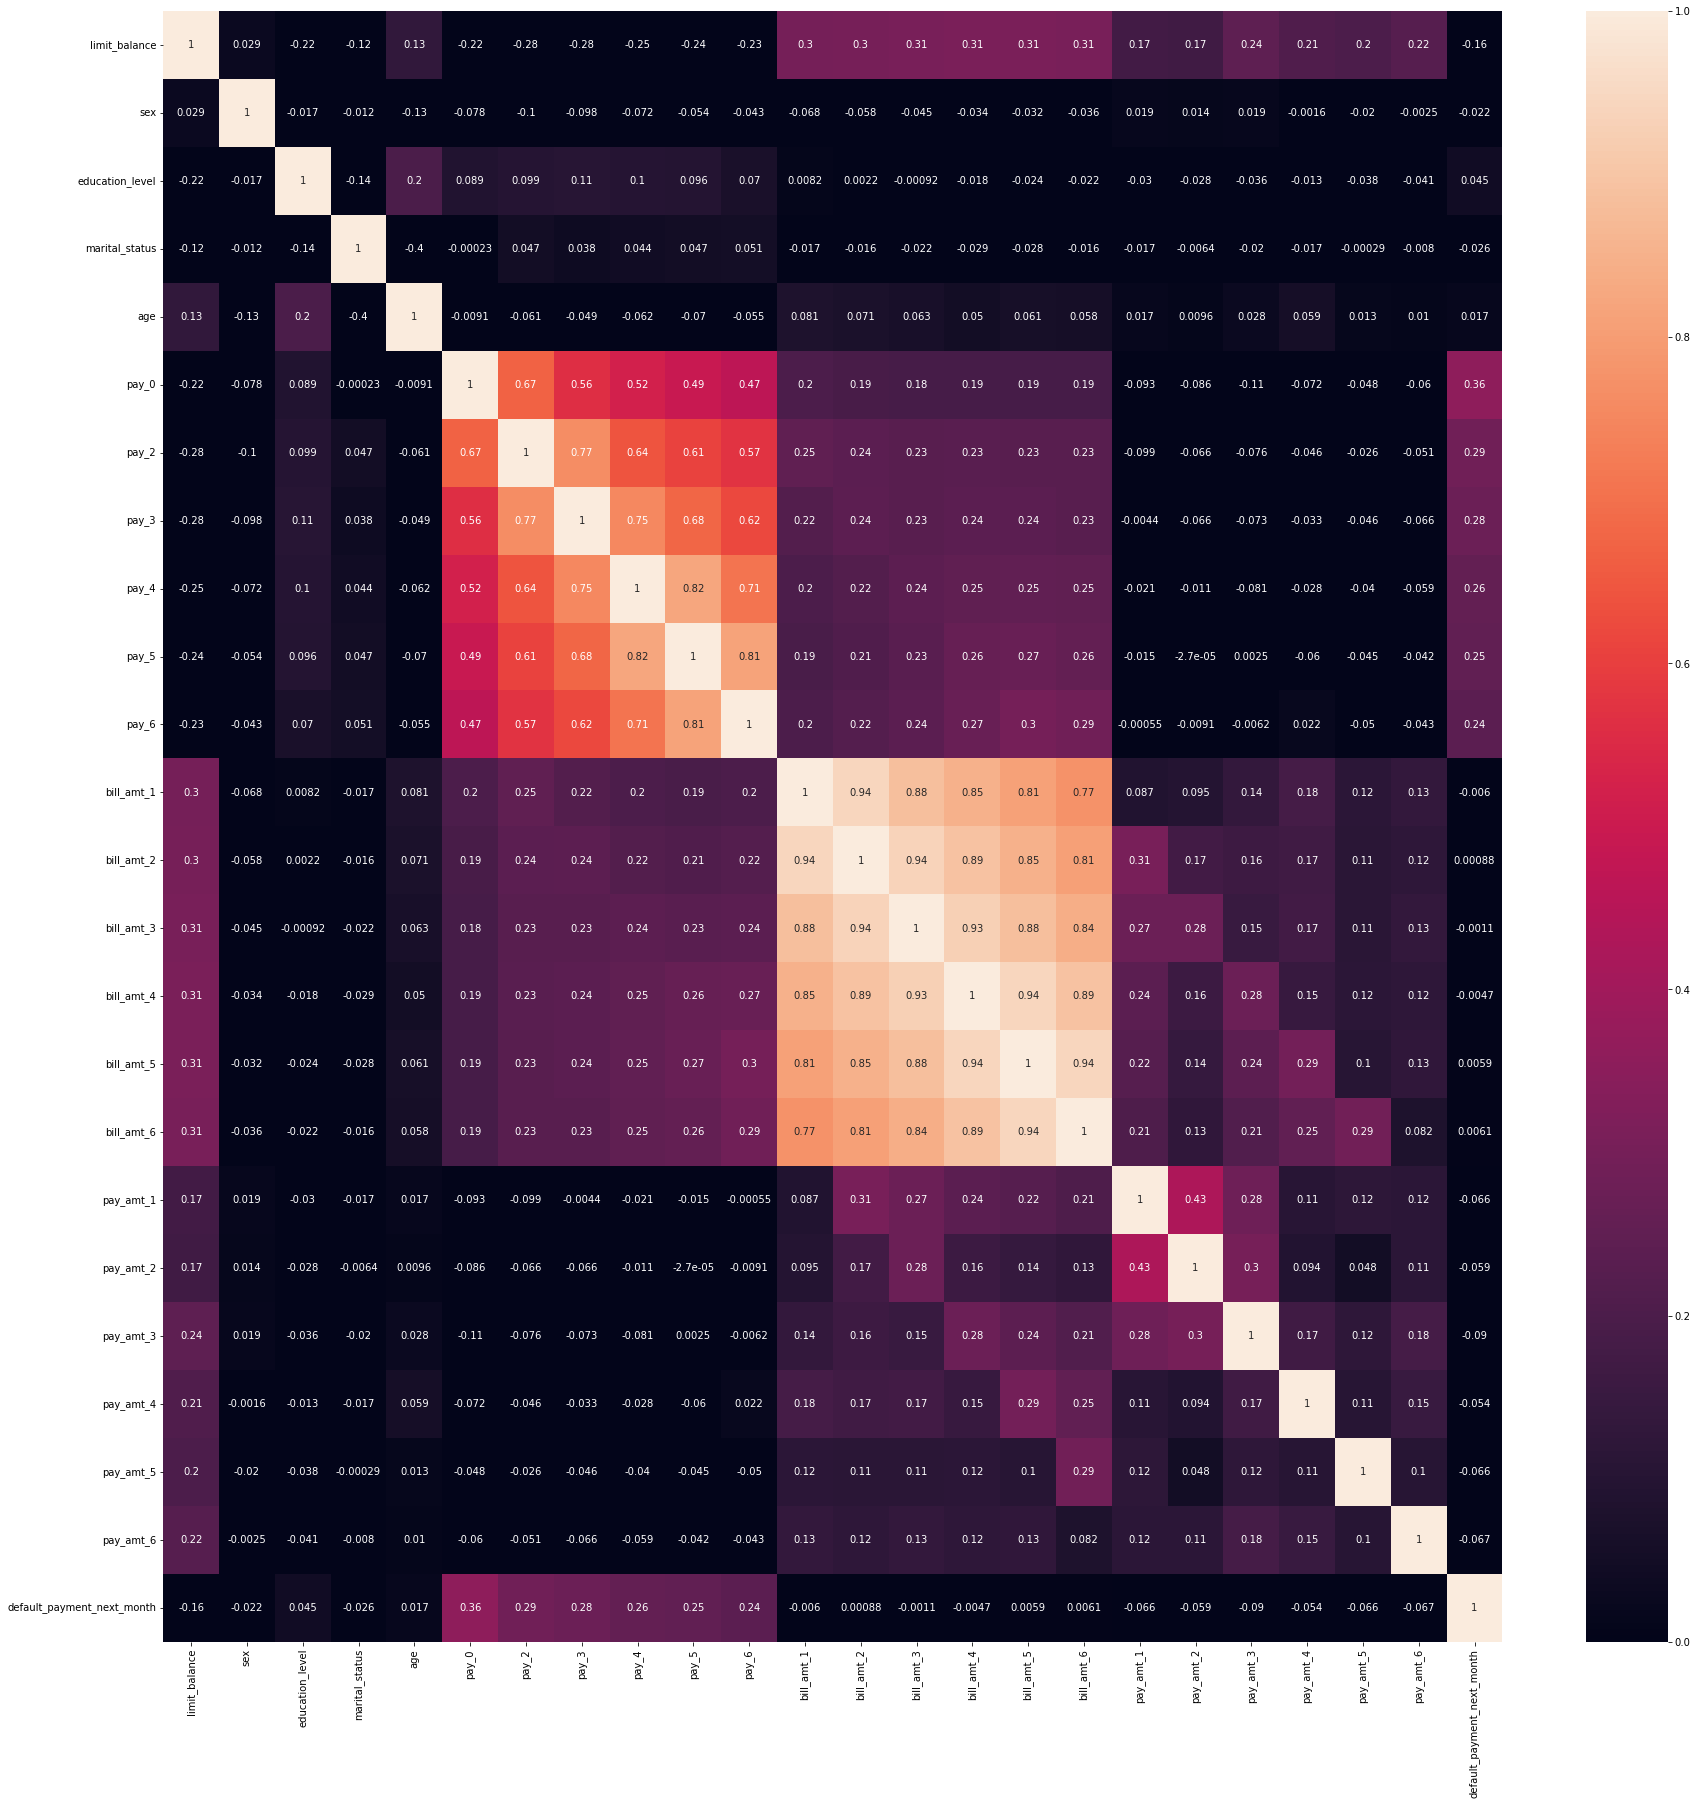

In [22]:
corr = df.corr()

plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot= True, vmin=0, vmax=1)
plt.show()

Dari peta di atas, kita dapat ketahui bahwa hanya nilai batas kredit dan status pembayaran 6 bulan terakhir yang memiliki pengaruh besar terhadap keputusan apakah seseorang harus membayar tagihan kredit mereka di bulan Oktober 2005 atau tidak.

## *Data Preprocessing*

### Mengambil dan Memisahkan *Data Inference*

Sebelum kita membagi *dataset train* dan *dataset test*, kita pisahkan dulu beberapa buah data untuk kita lakukan *inferencing* nantinya.

In [23]:
df_inf = df.sample(10, random_state = 20)
df_inf

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2498,200000,1,1,2,30,-1,-1,-1,-1,0,...,54271,60326,63339,3449,2798,54271,7000,4000,6000,0
1817,50000,1,2,2,27,2,2,2,2,2,...,36724,45751,46497,460,5021,0,10000,2005,37,1
596,410000,2,1,2,31,0,0,0,0,0,...,135954,134250,129971,15003,15877,30000,14250,9971,27380,0
735,100000,1,1,2,30,0,0,0,0,0,...,97862,79099,79812,4511,3711,3685,2797,2897,3046,1
2135,310000,1,1,1,45,-2,-2,-2,-2,-2,...,-16,-16,-16,1174,6527,0,0,0,0,0
2646,20000,1,1,2,24,-1,-1,-1,-1,-1,...,780,0,0,390,390,780,0,0,0,0
14,230000,1,2,1,41,0,0,0,0,0,...,216260,215968,174195,9405,7769,7757,8030,6549,5226,1
1151,100000,1,5,1,38,0,0,0,0,0,...,96038,94646,96631,3824,4311,3648,3370,3492,3614,0
1251,50000,2,2,1,32,0,0,0,0,0,...,8337,2475,0,1500,1847,1000,0,0,0,0
1912,20000,1,1,2,24,2,2,2,2,2,...,6346,6099,7235,4000,0,1000,0,1237,1000,1


Kemudian kita pisahkan sampel data tadi dari *dataset* aslinya.

In [24]:
df_traintest = df.drop(df_inf.index)
df_traintest.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

### Memisahkan *Data Train* dan *Data Test*

Setelah kita memisahkan *dataset inference* dengan *dataset* aslinya, kita pisahkan lebih lanjut *dataset* yang sudah dipisahkan menjadi tabel fitur dan tabel target. Pada kasus ini target yang dipilih adalah kolom `default_payment_next_month`.

In [25]:
x = df_traintest.drop("default_payment_next_month", axis = 1)
y = df_traintest["default_payment_next_month"]

Kemudian dengan bantuan *library* `sklearn.model_selection.train_test_split`, kita akan memisahkan tabel fitur dan target menjadi *dataset train* dan *dataset test*.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 20)

x_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

print("Train Size:", x_train.shape)
print("Test Size:", x_test.shape)

Train Size: (2364, 23)
Test Size: (591, 23)


### Mengurus *Outlier Value*

Di dalam data numerik yang kita miliki, keseluruhan datanya merupakan data asli yang tidak dapat kita lakukan perlakuan apapun terhadap nilai *outlier*-nya.

### Mengurus *Missing Value*

Seperti yang sudah kita ketahui pada saat melakukan *exploratory data analysis*, kita mengetahui bahwa terdapat data-data yang tidak termasuk di dalam skema deskripsi. Kita akan memasukkan indeks '-2' dan '0' yang tidak terdapat di dalam skema deskripsi ke dalam indeks '-1' dan kita ubah namanya ke indeks '0'.

In [27]:
for i in range(len(x_train)):
    if x_train.pay_0.iloc[i] < 0: x_train.pay_0.iloc[i] = 0
    else: continue

for i in range(len(x_train)):
    if x_train.pay_2.iloc[i] < 0: x_train.pay_2.iloc[i] = 0
    else: continue

for i in range(len(x_train)):
    if x_train.pay_3.iloc[i] < 0: x_train.pay_3.iloc[i] = 0
    else: continue

for i in range(len(x_train)):
    if x_train.pay_4.iloc[i] < 0: x_train.pay_4.iloc[i] = 0
    else: continue

for i in range(len(x_train)):
    if x_train.pay_5.iloc[i] < 0: x_train.pay_5.iloc[i] = 0
    else: continue

for i in range(len(x_train)):
    if x_train.pay_6.iloc[i] < 0: x_train.pay_6.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_0.iloc[i] < 0: x_test.pay_0.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_2.iloc[i] < 0: x_test.pay_2.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_3.iloc[i] < 0: x_test.pay_3.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_4.iloc[i] < 0: x_test.pay_4.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_5.iloc[i] < 0: x_test.pay_5.iloc[i] = 0
    else: continue

for i in range(len(x_test)):
    if x_test.pay_6.iloc[i] < 0: x_test.pay_6.iloc[i] = 0
    else: continue

Setelah kita mengurus *missing value*-nya, kita bisa mulai memilih dan mengolah tabel yang akan kita gunakan untuk diimplementasikan ke dalam model.

## Membangun Model yang akan Digunakan

### *Feature Selection*

Sebelum kita mulai memilih fitur apa yang akan kita gunakan, kita akan mengelompokkan batas kredit pengguna ke dalam kelipatan 200000 NTD, di mana secara lebih detil pembagiannya adalah sebagai berikut:

* Indeks '0': `limit_balance` $<$ 200000

* Indeks '1': 200000 $\leq$ `limit_balance` $<$ 400000

* Indeks '2': 400000 $\leq$ `limit_balance` $<$ 600000

* Indeks '3': 600000 $\leq$ `limit_balance` $<$ 800000

* Indeks '4': `limit_balance` $>$ 800000

Parameter baru ini akan kita namakan `limit_balance_general`.

In [28]:
limit_gen_train = []
limit_gen_test = []

for i in range(len(x_train)):
    if x_train.limit_balance.iloc[i] < 200000:
        limit_ind = 0
    elif x_train.limit_balance.iloc[i] >= 200000 and x_train.limit_balance.iloc[i] < 400000:
        limit_ind = 1
    elif x_train.limit_balance.iloc[i] >= 400000 and x_train.limit_balance.iloc[i] < 600000:
        limit_ind = 2
    elif x_train.limit_balance.iloc[i] >= 600000 and x_train.limit_balance.iloc[i] < 800000:
        limit_ind = 3
    else:
        limit_ind = 4
    limit_gen_train.append(limit_ind)

for i in range(len(x_test)):
    if x_test.limit_balance.iloc[i] < 200000:
        limit_ind = 0
    elif x_test.limit_balance.iloc[i] >= 200000 and x_test.limit_balance.iloc[i] < 400000:
        limit_ind = 1
    elif x_test.limit_balance.iloc[i] >= 400000 and x_test.limit_balance.iloc[i] < 600000:
        limit_ind = 2
    elif x_test.limit_balance.iloc[i] >= 600000 and x_test.limit_balance.iloc[i] < 800000:
        limit_ind = 3
    else:
        limit_ind = 4
    limit_gen_test.append(limit_ind)

x_train["limit_balance_general"] = limit_gen_train
x_test["limit_balance_general"] = limit_gen_test

Berdasarkan *heat map* yang sudah dibuat sebelumnya, kita akan memilih fitur `limit_balance_general` (kolom `limit_balance` yang sudah dikelompokkan ulang menjadi kelompok yang lebih besar), `pay_0`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, dan `pay_6` untuk dimasukkan ke dalam model.

In [29]:
x_train = x_train[["limit_balance_general", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]]
x_test = x_test[["limit_balance_general", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]]

Kebetulan, semua fitur yang dipilih merupakan fitur kategorik ordinal. Maka kita tidak perlu memisahkan kedua tabel tersebut berdasarkan jenis fiturnya.

### *Feature Encoding*

Setelah kita memilih fitur apa saja yang akan kita gunakan, kita akan lakukan *scaling* dan *encoding* sesuai dengan jenis fiturnya. Berhubung kita hanya memiliki fitur kategorik ordinal, kita hanya akan melakukan proses *ordinal encoding* pada *dataset train* dan *dataset test*.

In [30]:
ord_encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
ord_encoder.fit(x_train)

x_train_final = ord_encoder.transform(x_train)
x_test_final = ord_encoder.transform(x_test)

### *Model Training*

Selanjutnya kita akan latih model-model yang akan kita gunakan untuk memprediksi wajib pembayaran pada pemegang kartu kredit. Model-model yang akan kita olah antara lain model regresi logistik, model *support vector classification*, model *decision tree*, model *random forest*, model *K-Nearest Neighbor*, model *Gaussian Naive-Bayes*, dan model *Multinomial Naive-Bayes*. Semua model yang akan dilatih hanya akan menggunakan parameter *default* agar nantinya kita dapat melakukan *hyperparameter tuning* dengan mengubah *hyperparameter* pada model yang nantinya diambil.

#### Regresi Logistik

Untuk model regresi logistik, kita akan gunakan dari *library* `sklearn.linear_model.LogisticRegression`.

In [31]:
%%time
mod_log = LogisticRegression()
mod_log.fit(x_train_final, y_train)

CPU times: total: 15.6 ms
Wall time: 1.22 s


LogisticRegression()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [32]:
y_pred_train_log = mod_log.predict(x_train_final)
y_pred_test_log = mod_log.predict(x_test_final)

#### *Support-Vector Machine*

Untuk model *support-vector machine*, kita akan gunakan dari *library* `sklearn.svm.SVC`.

In [33]:
%%time
mod_SVM = SVC()
mod_SVM.fit(x_train_final, y_train)

CPU times: total: 219 ms
Wall time: 361 ms


SVC()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [34]:
y_pred_train_svc = mod_SVM.predict(x_train_final)
y_pred_test_svc = mod_SVM.predict(x_test_final)

#### *Decision Tree*

Untuk model *decision tree*, kita akan gunakan dari *library* `sklearn.tree.DecisionTreeClassifier`.

In [35]:
%%time
mod_tree = DecisionTreeClassifier()
mod_tree.fit(x_train_final, y_train)

CPU times: total: 0 ns
Wall time: 22 ms


DecisionTreeClassifier()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [36]:
y_pred_train_tree = mod_tree.predict(x_train_final)
y_pred_test_tree = mod_tree.predict(x_test_final)

#### *Random Forest*

Untuk model *random forest*, kita akan gunakan dari *library* `sklearn.ensemble.RandomForestClassifier`.

In [37]:
%%time
mod_rnd = RandomForestClassifier()
mod_rnd.fit(x_train_final, y_train)

CPU times: total: 359 ms
Wall time: 357 ms


RandomForestClassifier()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [38]:
y_pred_train_rnd = mod_rnd.predict(x_train_final)
y_pred_test_rnd = mod_rnd.predict(x_test_final)

#### KNN

Untuk model *K-nearest neighbor*, kita akan gunakan dari *library* `sklearn.neighbors.KNeighborsClassifier`.

In [39]:
%%time
mod_knn = KNeighborsClassifier()
mod_knn.fit(x_train_final, y_train)

CPU times: total: 15.6 ms
Wall time: 467 ms


KNeighborsClassifier()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [40]:
y_pred_train_knn = mod_knn.predict(x_train_final)
y_pred_test_knn = mod_knn.predict(x_test_final)

#### Naive-Bayes

Untuk model Naive-Bayes, kita akan gunakan dari *library* `sklearn.naive_bayes.GaussianNB`.

In [41]:
%%time
mod_gnb = GaussianNB()
mod_gnb.fit(x_train_final, y_train)

CPU times: total: 0 ns
Wall time: 5 ms


GaussianNB()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [42]:
y_pred_train_gnb = mod_gnb.predict(x_train_final)
y_pred_test_gnb = mod_gnb.predict(x_test_final)

#### Model Lain

Untuk model lain, saya akan menggunakan model Naive-Bayes Multinomial dari *library* `sklearn.naive_bayes.MultinomialNB`.

In [43]:
%%time
mod_mnb = MultinomialNB()
mod_mnb.fit(x_train_final, y_train)

CPU times: total: 46.9 ms
Wall time: 705 ms


MultinomialNB()

Kemudian kita akan prediksi hasil target dengan menggunakan model tersebut.

In [44]:
y_pred_train_mnb = mod_mnb.predict(x_train_final)
y_pred_test_mnb = mod_mnb.predict(x_test_final)

Lalu kita akan gabungkan hasil prediksi dari setiap model dengan hasil aslinya agar dapat kita bandingkan.

In [45]:
y_train_df = pd.DataFrame(y_train, columns = ["default_payment_next_month"]).reset_index(drop=True)
y_pred_train_log_df = pd.DataFrame(y_pred_train_log, columns = ["pred_log"])
y_pred_train_svc_df = pd.DataFrame(y_pred_train_svc, columns = ["pred_svc"])
y_pred_train_tree_df = pd.DataFrame(y_pred_train_tree, columns = ["pred_tree"])
y_pred_train_rnd_df = pd.DataFrame(y_pred_train_rnd, columns = ["pred_rnd"])
y_pred_train_knn_df = pd.DataFrame(y_pred_train_knn, columns = ["pred_knn"])
y_pred_train_gnb_df = pd.DataFrame(y_pred_train_gnb, columns = ["pred_gnb"])
y_pred_train_mnb_df = pd.DataFrame(y_pred_train_mnb, columns = ["pred_mnb"])
y_pred_comp = pd.concat([y_train_df, y_pred_train_log_df, y_pred_train_svc_df, y_pred_train_tree_df, y_pred_train_rnd_df, y_pred_train_knn_df, y_pred_train_gnb_df, y_pred_train_mnb_df], axis = 1)
y_pred_comp

,default_payment_next_month,pred_log,pred_svc,pred_tree,pred_rnd,pred_knn,pred_gnb,pred_mnb
0,0,1,1,1,1,1,1,0
1,1,1,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2359,1,1,1,1,1,1,1,1
2360,0,0,0,0,0,0,1,0
2361,0,0,0,0,0,0,0,0
2362,0,0,0,0,0,0,0,0


Dari tabel di atas kita dapat melihat bahwa setiap model memiliki ketidakakuratan pada data-data tertentu, sehingga kita harus membandingkan tingkat akurasi dari setiap model.

### *Model Evaluation*

Sekarang kita akan evaluasi setiap model yang telah kita latih satu sama lain.

#### Regresi Logistik

Mari kita lihat laporan klasifikasi dari model regresi logistik:

In [46]:
print(classification_report(y_train, y_pred_train_log))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1854
           1       0.74      0.41      0.53       510

    accuracy                           0.84      2364
   macro avg       0.80      0.69      0.72      2364
weighted avg       0.83      0.84      0.82      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model regresi logistik:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 86% dan prediksi wajib membayar dengan presisi 74%,

* Model ini memiliki akurasi keseluruhan sebesar 84%.

Kemudian kita akan lihat juga laporan pada *dataset test* dari model regresi linear:

In [67]:
print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       470
           1       0.67      0.32      0.44       121

    accuracy                           0.83       591
   macro avg       0.76      0.64      0.67       591
weighted avg       0.81      0.83      0.80       591



Dari sini kita dapat melihat bahwa model regresi logistik yang dibuat memiliki akurasi keseluruhan sebesar 83% pada *dataset test*, sehingga kita dapat mengetahui bahwa model regresi logistik ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### *Support-Vector Machine*

Mari kita lihat laporan klasifikasi dari SVM:

In [47]:
print(classification_report(y_train, y_pred_train_svc))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1854
           1       0.75      0.45      0.56       510

    accuracy                           0.85      2364
   macro avg       0.81      0.71      0.74      2364
weighted avg       0.84      0.85      0.83      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model SVM:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 86% dan prediksi wajib membayar dengan presisi 75%,

* Model ini memiliki akurasi keseluruhan sebesar 85%.

In [68]:
print(classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       470
           1       0.61      0.34      0.44       121

    accuracy                           0.82       591
   macro avg       0.73      0.64      0.66       591
weighted avg       0.80      0.82      0.80       591



Dari sini kita dapat melihat bahwa model SVM yang dibuat memiliki akurasi keseluruhan sebesar 82% pada *dataset test*, sehingga kita dapat mengetahui bahwa model SVM ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### *Decision Tree*

Mari kita lihat laporan klasifikasi dari model *decision tree*:

In [48]:
print(classification_report(y_train, y_pred_train_tree))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1854
           1       0.81      0.44      0.57       510

    accuracy                           0.86      2364
   macro avg       0.83      0.70      0.74      2364
weighted avg       0.85      0.86      0.84      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model *decision tree*:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 86% dan prediksi wajib membayar dengan presisi 81%,

* Model ini memiliki akurasi keseluruhan sebesar 86%.

In [69]:
print(classification_report(y_test, y_pred_test_tree))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       470
           1       0.62      0.31      0.41       121

    accuracy                           0.82       591
   macro avg       0.73      0.63      0.65       591
weighted avg       0.80      0.82      0.79       591



Dari sini kita dapat melihat bahwa model *decision tree* yang dibuat memiliki akurasi keseluruhan sebesar 82% pada *dataset test*, sehingga kita dapat mengetahui bahwa model *decision tree* ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### *Random Forest*

Mari kita lihat laporan klasifikasi dari model *random forest*:

In [49]:
print(classification_report(y_train, y_pred_train_rnd))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1854
           1       0.79      0.45      0.58       510

    accuracy                           0.86      2364
   macro avg       0.83      0.71      0.74      2364
weighted avg       0.85      0.86      0.84      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model *random forest*:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 87% dan prediksi wajib membayar dengan presisi 78%,

* Model ini memiliki akurasi keseluruhan sebesar 86%.

In [70]:
print(classification_report(y_test, y_pred_test_rnd))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       470
           1       0.63      0.32      0.43       121

    accuracy                           0.82       591
   macro avg       0.74      0.64      0.66       591
weighted avg       0.80      0.82      0.80       591



Dari sini kita dapat melihat bahwa model *random forest* yang dibuat memiliki akurasi keseluruhan sebesar 82% pada *dataset test*, sehingga kita dapat mengetahui bahwa model *random forest* ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### KNN

Mari kita lihat laporan klasifikasi dari model *K-Nearest Neighbor*:

In [50]:
print(classification_report(y_train, y_pred_train_knn))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1854
           1       0.74      0.44      0.55       510

    accuracy                           0.85      2364
   macro avg       0.80      0.70      0.73      2364
weighted avg       0.84      0.85      0.83      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model *K-nearest neighbor*:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 86% dan prediksi wajib membayar dengan presisi 74%,

* Model ini memiliki akurasi keseluruhan sebesar 85%.

In [71]:
print(classification_report(y_test, y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       470
           1       0.62      0.32      0.42       121

    accuracy                           0.82       591
   macro avg       0.73      0.64      0.66       591
weighted avg       0.80      0.82      0.80       591



Dari sini kita dapat melihat bahwa model *K-nearest neighbor* yang dibuat memiliki akurasi keseluruhan sebesar 82% pada *dataset test*, sehingga kita dapat mengetahui bahwa model *K-nearest neighbor* ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### Naive-Bayes

Mari kita lihat laporan klasifikasi dari model Naive-Bayes Gaussian:

In [51]:
print(classification_report(y_train, y_pred_train_gnb))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1854
           1       0.58      0.50      0.54       510

    accuracy                           0.82      2364
   macro avg       0.73      0.70      0.71      2364
weighted avg       0.81      0.82      0.81      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model Naive-Bayes Gaussian:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 87% dan prediksi wajib membayar dengan presisi 58%,

* Model ini memiliki akurasi keseluruhan sebesar 82%.

Dari sini kita dapat melihat bahwa model regresi logistik yang dibuat memiliki akurasi keseluruhan sebesar 83% pada *dataset test*, sehingga kita dapat mengetahui bahwa model regresi logistik ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

In [72]:
print(classification_report(y_test, y_pred_test_gnb))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       470
           1       0.60      0.54      0.57       121

    accuracy                           0.83       591
   macro avg       0.74      0.72      0.73       591
weighted avg       0.83      0.83      0.83       591



Dari sini kita dapat melihat bahwa model Naive-Bayes Gaussian yang dibuat memiliki akurasi keseluruhan sebesar 83% pada *dataset test*, sehingga kita dapat mengetahui bahwa model Naive-Bayes Gaussian ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

#### Model Lain

Mari kita lihat laporan klasifikasi dari model Naive-Bayes Multinomial:

In [52]:
print(classification_report(y_train, y_pred_train_mnb))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      1854
           1       0.60      0.41      0.49       510

    accuracy                           0.81      2364
   macro avg       0.72      0.67      0.69      2364
weighted avg       0.80      0.81      0.80      2364



Berikut adalah beberapa hal yang dapat disimpulkan dari laporan klasifikasi model Naive-Bayes Multinomial:

* Model ini memiliki prediksi tidak wajib membayar dengan presisi 85% dan prediksi wajib membayar dengan presisi 60%,

* Model ini memiliki akurasi keseluruhan sebesar 81%.

In [74]:
print(classification_report(y_test, y_pred_test_mnb))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       470
           1       0.56      0.40      0.47       121

    accuracy                           0.81       591
   macro avg       0.71      0.66      0.68       591
weighted avg       0.80      0.81      0.80       591



Dari sini kita dapat melihat bahwa model Naive-Bayes Multinomial yang dibuat memiliki akurasi keseluruhan sebesar 81% pada *dataset test*, sehingga kita dapat mengetahui bahwa model Naive-Bayes Multinomial ini merupakan model yang *good-fit* untuk diterapkan ke dalam data.

Selain itu, kita dapat menyimpulkan beberapa hal dari laporan klasifikasi dari setiap model yang telah kita latih, di antaranya:

* Untuk prediksi tidak wajib membayar yang benar, model Naive-Bayes Gaussian dan model *random forest* memiliki persentase presisi paling tinggi diantara model-model algoritma yang lain dengan nilai sebesar 87%,

* Untuk prediksi wajib membayar yang benar, model *decision tree* memiliki persentase presisi paling tinggi diantara model-model algoritma yang lain dengan nilai sebesar 81%,

* Model *decision tree* dan model *random forest* memiliki akurasi keseluruhan terbesar dibanding model-model yang lain dengan persentase akurasi sebesar 86%

* Seluruh model yang telah dilatih merupakan model yang *good-fit* untuk diterapkan ke dalam *dataset*, namun model regresi logistik merupakan model terbaik yang dapat digunakan dengan keseluruhan akurasi prediksi *dataset train* dan *dataset test* rata-rata tertinggi dan dengan nilai variasi yang paling kecil.

#### Memilih Model Terbaik yang akan Digunakan

Kali ini kita akan memilih model mana yang terbaik untuk digunakan pada proses *inferencing*. Kita akan menggunakan bantuan dari *library* `sklearn.model_selection.cross_val_score`.

In [53]:
score_log = cross_val_score(mod_log, x_train_final, y_train, cv = 5)
score_SVM = cross_val_score(mod_SVM, x_train_final, y_train, cv = 5)
score_tree = cross_val_score(mod_tree, x_train_final, y_train, cv = 5)
score_rnd = cross_val_score(mod_rnd, x_train_final, y_train, cv = 5)
score_knn = cross_val_score(mod_knn, x_train_final, y_train, cv = 5)
score_gnb = cross_val_score(mod_mnb, x_train_final, y_train, cv = 5)
score_mnb = cross_val_score(mod_mnb, x_train_final, y_train, cv = 5)

print("----------")
print("Skor (Logistic):", score_log)
print("Skor (SVM):", score_SVM)
print("Skor (DTree):", score_tree)
print("Skor (RNF):", score_rnd)
print("Skor (KNN):", score_knn)
print("Skor (Gaussian Naive-Bayes):", score_mnb)
print("Skor (Multinominal Naive-Bayes):", score_mnb)
print("----------")
print("Mean Skor (Logistic):", score_log.mean())
print("Mean Skor (SVM):", score_SVM.mean())
print("Mean Skor (DTree):", score_tree.mean())
print("Mean Skor (RNF):", score_rnd.mean())
print("Mean Skor (KNN):", score_knn.mean())
print("Mean Skor (Gaussian Naive-Bayes):", score_gnb.mean())
print("Mean Skor (Multinominal Naive-Bayes):", score_mnb.mean())
print("----------")
print("Std Skor (Logistic):", score_log.std())
print("Std Skor (SVM):", score_SVM.std())
print("Std Skor (DTree):", score_tree.std())
print("Std Skor (RNF):", score_rnd.std())
print("Std Skor (KNN):", score_knn.std())
print("Std Skor (Gaussian Naive-Bayes):", score_gnb.std())
print("Std Skor (Multinominal Naive-Bayes):", score_mnb.std())
print("----------")

----------
Skor (Logistic): [0.83509514 0.84989429 0.82663848 0.8435518  0.84745763]
Skor (SVM): [0.83932347 0.85200846 0.82241015 0.84989429 0.83474576]
Skor (DTree): [0.83086681 0.83509514 0.80972516 0.84566596 0.82838983]
Skor (RNF): [0.82663848 0.84143763 0.81606765 0.84778013 0.82838983]
Skor (KNN): [0.54122622 0.82875264 0.81818182 0.84989429 0.83686441]
Skor (Gaussian Naive-Bayes): [0.794926   0.82875264 0.8012685  0.83298097 0.81144068]
Skor (Multinominal Naive-Bayes): [0.794926   0.82875264 0.8012685  0.83298097 0.81144068]
----------
Mean Skor (Logistic): 0.8405274662271115
Mean Skor (SVM): 0.8396764252696457
Mean Skor (DTree): 0.8299485792095174
Mean Skor (RNF): 0.8320627441143799
Mean Skor (KNN): 0.7749838750134375
Mean Skor (Gaussian Naive-Bayes): 0.8138737592718673
Mean Skor (Multinominal Naive-Bayes): 0.8138737592718673
----------
Std Skor (Logistic): 0.008571176384471954
Std Skor (SVM): 0.010761450993163635
Std Skor (DTree): 0.011711385614501517
Std Skor (RNF): 0.011257

Dari laporan di atas, kita dapat simpulkan bahwa model regresi logistik merupakan model terbaik yang akan kita gunakan di dalam proses *inferencing*.

#### *Hyperparameter Tuning*

Sebelum kita menerapkan model yang telah kita pilih untuk diterapkan ke dalam data *inference*, kita akan periksa *hyperparameter* apa saja yang harus kita gunakan di dalam model tersebut. Untuk model regresi logistik, kita bisa mengatur 4 jenis parameter, yaitu parameter 'solver', parameter 'multi_class', parameter 'C', dan parameter 'max_iter'.

In [54]:
parameter = [{"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]},
            {"multi_class": ["auto", "ovr", "multinomial"]},
            {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {"max_iter": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]}]

Kemudian dengan bantuan *library* `sklearn.model_selection.GridSearchCV`, kita akan mencari parameter apa saja yang harus kita gunakan pada saat membangun model.

In [55]:
mod_grid = GridSearchCV(LogisticRegression(), parameter, cv = 5)

Kemudian kita akan latih model tersebut untuk mencari parameter terbaik di dalam model regresi logistik yang akan kita buat ulang nantinya.

In [56]:
mod_grid.fit(x_train_final, y_train)
print("Best parameters: {}".format(mod_grid.best_params_))
print("Best cross-validation score: {:.2f}".format(mod_grid.best_score_))

Best parameters: {'C': 0.1}
Best cross-validation score: 0.84


Dari perintah di atas, kita mengetahui bahwa parameter terbaik untuk model yang kita buat adalah parameter 'C' bernilai 0.1 dan parameter lainnya dibiarkan dalam mode *default*.

Dengan parameter di atas, kita akan membuat model regresi linear baru dengan parameter yang sudah diatur.

In [57]:
%%time
mod_log_fine = LogisticRegression(C = 0.1)
mod_log_fine.fit(x_train_final, y_train)

CPU times: total: 0 ns
Wall time: 8 ms


LogisticRegression(C=0.1)

Kemudian kita akan lakukan prediksi dengan menggunakan model tersebut.

In [58]:
y_pred_train_log_fine = mod_log_fine.predict(x_train_final)
y_pred_test_log_fine = mod_log_fine.predict(x_test_final)

Dan kita akan bandingkan hasil prediksinya berdampingan dengan hasil aslinya.

In [59]:
y_pred_train_log_fine_df = pd.DataFrame(y_pred_train_log_fine, columns = ["pred_log_fine"])
pd.concat([y_train_df, y_pred_train_log_fine_df], axis = 1)

,default_payment_next_month,pred_log_fine
0,0,1
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
2359,1,1
2360,0,0
2361,0,0
2362,0,0


Bila kita lihat seperti ini, tidak terdapat perubahan yang signifikan terhadap prediksi yang dihasilkan.

Selain itu, kita akan buat laporan klasifikasi *dataset train* dari model yang sudah diatur tersebut.

In [60]:
print(classification_report(y_train, y_pred_train_log_fine))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1854
           1       0.74      0.41      0.53       510

    accuracy                           0.84      2364
   macro avg       0.80      0.69      0.72      2364
weighted avg       0.83      0.84      0.82      2364



Setra laporan klasifikasi *dataset test* dari model yang sudah diatur.

In [75]:
print(classification_report(y_test, y_pred_test_log_fine))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       470
           1       0.66      0.32      0.43       121

    accuracy                           0.83       591
   macro avg       0.75      0.64      0.67       591
weighted avg       0.81      0.83      0.80       591



Dari laporan di atas, kita dapat mengetahui bahwa presisi prediksi tidak wajib membayar pada *dataset train* sebesar 86%, presisi prediksi wajib membayar sebesar 74%, dan akurasi keseluruhan sebesar 84% pada *dataset train* dan 83% pada *dataset test*. Bila kita lihat nilai ini tidak jauh berbeda dengan nilai yang terdapat pada laporan klasifikasi model regresi logistik yang pertama. 

Untuk melihat perbandingannya secara lebih jelas, kita akan lihat nilai *cross validation* model regresi logistik dan nilai *cross validation* model regresi logistik yang pertama.

In [61]:
score_log_fine = cross_val_score(mod_log_fine, x_train_final, y_train, cv = 5)

print("----------")
print("Skor (Logistic):", score_log)
print("Skor (Logistic-Fine):", score_log_fine)
print("----------")
print("Mean Skor (Logistic):", score_log.mean())
print("Mean Skor (Logistic-Fine):", score_log_fine.mean())
print("----------")
print("Std Skor (Logistic):", score_log.std())
print("Std Skor (Logistic-Fine):", score_log_fine.std())
print("----------")

----------
Skor (Logistic): [0.83509514 0.84989429 0.82663848 0.8435518  0.84745763]
Skor (Logistic-Fine): [0.83298097 0.85200846 0.82663848 0.84566596 0.84745763]
----------
Mean Skor (Logistic): 0.8405274662271115
Mean Skor (Logistic-Fine): 0.8409502992080838
----------
Std Skor (Logistic): 0.008571176384471954
Std Skor (Logistic-Fine): 0.009541530670863824
----------


Dari hasil di atas, dapat kita lihat bahwa skor untuk model regresi logistik pertama sedikit lebih kecil apabila dibandingkan dengan model regresi logistik yang sudah di-*tuning*. Meskipun begitu, model yang sudah di-*tune* memiliki nilai standar deviasi yang sedikit lebih besar dibanding dengan model regresi logistik yang pertama.

## *Inferencing*

Setelah kita menentukan model apa yang akan kita gunakan, kita akan gunakan model tersebut untuk melakukan *inferencing*. Sebelumnya, kita akan olah tabel sesuai dengan apa yang kita lakukan pada *dataset train* dan *dataset test*, yaitu mengklasifikasi ulang klasifikasi status pembayaran dan pengelompokan ulang batas kredit menjadi kelompok yang lebih besar.

In [62]:
limit_gen_inf = []

for i in range(len(df_inf)):
    if df_inf.limit_balance.iloc[i] < 200000:
        limit_ind = 0
    elif df_inf.limit_balance.iloc[i] >= 200000 and df_inf.limit_balance.iloc[i] < 400000:
        limit_ind = 1
    elif df_inf.limit_balance.iloc[i] >= 400000 and df_inf.limit_balance.iloc[i] < 600000:
        limit_ind = 2
    elif df_inf.limit_balance.iloc[i] >= 600000 and df_inf.limit_balance.iloc[i] < 800000:
        limit_ind = 3
    else:
        limit_ind = 4
    limit_gen_inf.append(limit_ind)

for i in range(len(df_inf)):
    if df_inf.pay_0.iloc[i] < 0: df_inf.pay_0.iloc[i] = 0
    else: continue

for i in range(len(df_inf)):
    if df_inf.pay_2.iloc[i] < 0:df_inf.pay_2.iloc[i] = 0
    else: continue

for i in range(len(df_inf)):
    if df_inf.pay_3.iloc[i] < 0: df_inf.pay_3.iloc[i] = 0
    else: continue

for i in range(len(df_inf)):
    if df_inf.pay_4.iloc[i] < 0: df_inf.pay_4.iloc[i] = 0
    else: continue

for i in range(len(df_inf)):
    if df_inf.pay_5.iloc[i] < 0: df_inf.pay_5.iloc[i] = 0
    else: continue

for i in range(len(df_inf)):
    if df_inf.pay_6.iloc[i] < 0: df_inf.pay_6.iloc[i] = 0
    else: continue

df_inf["limit_balance_general"] = limit_gen_inf

Setelah kita memodifikasi *dataset inference* yang kita miliki, kita akan ambil fitur kolom yang kita gunakan untuk melakukan *encoding*.

In [63]:
df_inf_ord = df_inf[["limit_balance_general", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]]
df_inf_final = ord_encoder.transform(df_inf_ord)

Kemudian kita akan terapkan model yang sudah kita atur *hyperparameter*-nya ke dalam *dataset inference*.

In [64]:
y_pred_inf_log_fine = mod_log_fine.predict(df_inf_final)

Setelah itu kita akan lihat hasil prediksinya apabila dibandingkan dengan hasil asli pada *data inference*-nya.

In [65]:
y_pred_inf_log_fine_df = pd.DataFrame(y_pred_inf_log_fine, columns = ["pred_logf"])

pd.concat([df_inf.default_payment_next_month, y_pred_inf_log_fine_df], axis = 1)

,default_payment_next_month,pred_logf
0,0,0
1,1,1
2,0,0
3,1,0
4,0,0
5,0,0
6,1,0
7,0,0
8,0,0
9,1,1


Dari hasil tersebut kita dapat lihat bahwa prediksi dari model yang sudah diatur *hyperparameter*-nya masih bisa meleset dari hasil data yang seharusnya meskipun akurasinya sudah cukup tinggi.

Setelah itu kita akan melihat bagaimana persamaan matematis regresi logistik dari model tersebut.

In [66]:
print("c (Intercept):", mod_log_fine.intercept_)
print("m (Slope):", mod_log_fine.coef_)

c (Intercept): [-1.86102623]
m (Slope): [[-0.33541035  1.10271078  0.00845416  0.38306362  0.0682506   0.10679345
   0.42189151]]


Dari perintah di atas, kita dapat mengetahui bahwa semakin besar batas kredit dari kartu yang dimiliki, maka akan semakin kecil kemungkinan seseorang untuk perlu membayar tagihan kredit mereka di bulan Oktober. Sebaliknya, orang yang memiliki keterlambatan pembayaran kredit selama 1 bulan akan lebih besar kemungkinannya untuk diharuskan memnbayar tagihan tersebut di bulan Oktober.

## Kesimpulan

Berikut ini adalah kesimpulan yang dapat diambil dari pengolahan data yang sudah dilakukan:

1. Berdasarkan EDA, kita ketahui bahwa data diambil dari pemegang kartu kredit di Taiwan pada rentang waktu April-September 2005 yang berjumlah 2965 orang dan berisi data-data batas kartu kredit, data diri, dan detil tagihan dan pembayaran kartu kredit untuk menentukan apakah seseorang harus membayar tagihan kartu kredit mereka atau tidak pada Oktober 2005,

2. Model-model yang sudah dilatih memiliki akurasi total yang relatif mirip satu sama lain dan semuanya merupakan model yang *good-fit* untuk diterapkan di dalam data, namun pada kasus ini, kita mengetahui dari metode `cross_val_score` bahwa model regresi logistik merupakan model terbaik yang dapat kita terapkan di model tersebut karena akurasi pada *dataset train* dan *dataset test*-nya paling besar dan tidak jauh berbeda nilainya satu sama lain,

3. Model regresi logistik yang sudah diperbaiki pada kasus ini hanya mengatur ulang *hyperparameter* C yang mengatur seberapa besar regulasi yang harus dilakukan. Pada kasus ini nilai C yang terbaik ternyata lebih kecil dari nilai asalnya sehingga model regresi logistik yang baru memiliki parameter regulasi yang lebih kuat,

4. Model regresi logistik yang baru memiliki akurasi total sebesar 84% untuk memprediksi apakah seseorang harus membayar tagihan kartu kredit mereka atau tidak, yang nilainya sedikit lebih baik dibanding dengan model regresi logistik dengan pengaturan *default* pada seluruh *hyperparameter*-nya,

5. Semakin besar batas kredit dari kartu yang dimiliki, maka akan semakin kecil kemungkinan seseorang untuk perlu membayar tagihan kredit mereka di bulan Oktober. Sebaliknya, orang yang memiliki keterlambatan pembayaran kredit selama 1 bulan akan lebih besar kemungkinannya untuk diharuskan memnbayar tagihan tersebut di bulan Oktober.

## Pertanyaan Konseptual

1. Apakah fungsi parameter `criterion` pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!

**Jawab:** Parameter `criterion` merupakan sebuah parameter yang mengukur akurasi dari pemisahan setiap keputusan di dalam *decision tree* ([Sumber 1](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). Salah satu parameter `criterion` yang terdapat di dalam model *decision tree* adalah 'gini', yang merupakan perhitungan untuk mengukur seberapa sering suatu data yang diambil diberikan label yang salah ([Sumber 2](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)).

2. Apakah fungsi dari `pruning` pada Tree model?

**Jawab:** Fungsi dari *pruning* adalah untuk mengurangi beban pekerjaan algoritma *decision tree* dengan memangkas fitur-fitur yang tidak terlalu dibutuhkan di dalam model ([Sumber 3](https://en.wikipedia.org/wiki/Decision_tree_pruning)).

3. Bagaimana cara memilih `K` yang optimal pada KNN?

**Jawab:** Cara memilih `K` yang optimal pada KNN adalah dengan melihat jumlah data yang akan diperiksa. Apabila datanya semakin banyak, maka nilai `K` yang dibutuhkan akan semakin besar tergantung dari nilai akar dari jumlah data yang ada.

4. Jelaskan apa yang kalian ketahui tentang `Cross Validation`!

**Jawab:** *Cross Validation* merupakan proses pemeriksaan model yang dilakukan berkali-kali dengan menggunakan berbagai macam *dataset train* dan *dataset test* yang berbeda-beda

5. Jelaskan apa yang kalian ketahui tentang `Accuracy, Precision, Recall, F1 Score`!

**Jawab:** `Accuracy` merupakan presisi keseluruhan dari model yang telah dilatih, `Precision` merupakan perbandingan dari prediksi positif yang benar dengan prediksi yang benar secara keseluruhan, `Recall` merupakan perbandingan dari prediksi benar dengan hasil aslinya, dan `F1 Score` merupakan nilai beban dari `Precision` dan `Recall` ([Sumber 4](https://www.statology.org/sklearn-classification-report/)).